Tests to run GenIce on Jupyter and Google Colaboratory.

In [2]:
# %pip install genice2

!pip install git+https://github.com/vitroid/GLRM.git

You are using pip version 19.0.3, however version 20.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


A simplest sample.

In [1]:
from genice.genice import GenIce
from genice.importer import safe_import

lattice    = safe_import("lattice", "ice11_19").Lattice() 
formatter  = safe_import("format", "gromacs").Format()
water      = safe_import("molecule", "spce").Molecule()
ice = GenIce(lattice).generate_ice(water, formatter)
print(ice)

Generated by GenIce https://github.com/vitroid/GenIce 
48
    1SOL     Ow    1   0.220  -0.003   0.095
    1SOL     Hw    2   0.302  -0.050   0.062
    1SOL     Hw    3   0.220   0.092   0.062
    2SOL     Ow    4   0.220   0.256   0.004
    2SOL     Hw    5   0.302   0.304   0.037
    2SOL     Hw    6   0.220   0.256  -0.096
    3SOL     Ow    7   0.229   0.003   0.370
    3SOL     Hw    8   0.229   0.003   0.270
    3SOL     Hw    9   0.148  -0.045   0.404
    4SOL     Ow   10   0.229   0.262   0.462
    4SOL     Hw   11   0.148   0.309   0.429
    4SOL     Hw   12   0.229   0.167   0.429
    5SOL     Ow   13   0.669  -0.003   0.095
    5SOL     Hw   14   0.751  -0.050   0.062
    5SOL     Hw   15   0.669   0.092   0.062
    6SOL     Ow   16   0.669   0.256   0.004
    6SOL     Hw   17   0.669   0.256  -0.096
    6SOL     Hw   18   0.751   0.304   0.037
    7SOL     Ow   19   0.678   0.003   0.370
    7SOL     Hw   20   0.678   0.003   0.270
    7SOL     Hw   21   0.597  -0.045   0.4

Install an extra package to show image inline.

In [ ]:
%pip install genice_svg

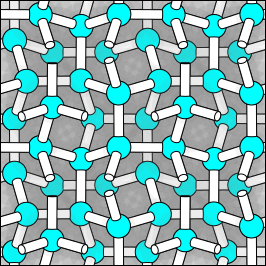

In [1]:
from genice.genice import GenIce
from genice.importer import safe_import

lattice    = safe_import("lattice", "ice3").Lattice() 
formatter  = safe_import("format", "svg").Format(shadow=True)
water      = safe_import("molecule", "spce").Molecule()
img = GenIce(lattice, rep=[2,2,2]).generate_ice(water, formatter)

from IPython.display import SVG, display
display(SVG(img))

PNG renderer is also included in gence_svg package.

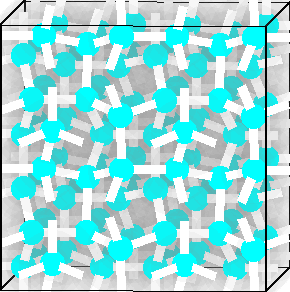

In [1]:
from genice.genice import GenIce
from genice.importer import safe_import

lattice    = safe_import("lattice", "ice3").Lattice() 
formatter  = safe_import("format", "png").Format(shadow="#8881",encode=False,bg="#fff",rotatex=5,rotatey=5)
water      = safe_import("molecule", "spce").Molecule()
img = GenIce(lattice, rep=[2,2,2]).generate_ice(water, formatter)

from IPython.display import display
display(img)

Or save it in a PNG file.

In [2]:
from genice.genice import GenIce
from genice.importer import safe_import

lattice    = safe_import("lattice", "ice3").Lattice() 
formatter  = safe_import("format", "png").Format(shadow="#8881",encode=True,bg="#fff",rotatex=5,rotatey=5)
water      = safe_import("molecule", "spce").Molecule()
img = GenIce(lattice, rep=[2,2,2]).generate_ice(water, formatter)

with open("ice3.png", "wb") as f:
    f.write(img)

Some statistical analyses are also available.

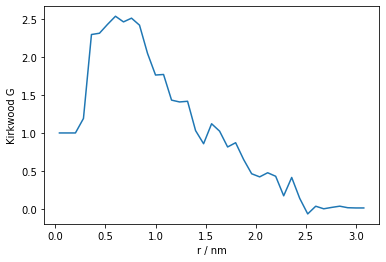

In [27]:
from genice.genice import GenIce
from genice.importer import safe_import

lattice    = safe_import("lattice", "T").Lattice() 
formatter  = safe_import("format", "_KG").Format()
water      = safe_import("molecule", "spce").Molecule()
result = GenIce(lattice).generate_ice(water, formatter)

import numpy as np
from matplotlib import pyplot as plt

kg = np.fromstring(result, dtype=float, sep=" ")
N = kg.shape[0]
kg = kg.reshape([N//2, 2])
plt.plot(kg[:,0], kg[:,1])
plt.xlabel("r / nm")
plt.ylabel("Kirkwood G")
plt.show()

You may want to see the process log.

In [14]:
from logging import getLogger, INFO, DEBUG, WARNING
logger = getLogger()
logger.setLevel(INFO)

from genice.genice import GenIce
from genice.importer import safe_import

lattice   = safe_import("lattice", "prism").Lattice(sides=5,rows=5) 
formatter = safe_import("format", "gromacs").Format()
water     = safe_import("molecule", "spce").Molecule()
ice = GenIce(lattice, comment="Jupyter test").generate_ice(water, formatter)
print(ice)

logger.setLevel(WARNING)

INFO:root:Prism ice with 5 sides and 5 rows.
INFO:root:  
INFO:root:  Jupyter test
INFO:root:No rotmatrices in lattice
INFO:root:Cell dimension:
INFO:root:  a = 55.0
INFO:root:  b = 55.0
INFO:root:  c = 13.75
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:HB connectivity is not defined.
INFO:root:Bond length (specified): 3
INFO:root:Target Density: 0.017965681057759416
INFO:root:Original Density: 1.7965681057759422e-05
INFO:root:Bond length (scaled, nm): 0.30000000000000004
INFO:root:Stage1: Replication.
INFO:root:  Number of water molecules: 25
INFO:root:  Pairs are not given explicitly.
INFO:root:  Estimating the bonds according to the pair distances.
INFO:root:  Number of water nodes: 25
INFO:root:Cell dimension:
INFO:root:  a = 5.500000000000001
INFO:root:  b = 5.500000000000001
INFO:root:  c = 1.3750000000000002
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:Stage1: end.
INFO:root:Stage2: Graph preparation.
INFO:root:  Number of 

Generated by GenIce https://github.com/vitroid/GenIce 
75
    1SOL     Ow    1   0.237   0.004  -0.005
    1SOL     Hw    2   0.179  -0.076  -0.021
    1SOL     Hw    3   0.247   0.017   0.094
    2SOL     Ow    4   0.070   0.226  -0.005
    2SOL     Hw    5   0.128   0.146  -0.021
    2SOL     Hw    6   0.060   0.240   0.094
    3SOL     Ow    7   5.306   0.136   0.005
    3SOL     Hw    8   5.400   0.167   0.021
    3SOL     Hw    9   5.290   0.131  -0.094
    4SOL     Ow   10   5.311   5.358   0.005
    4SOL     Hw   11   5.311   5.341  -0.094
    4SOL     Hw   12   5.311   5.457   0.021
    5SOL     Ow   13   0.077   5.276   0.005
    5SOL     Hw   14  -0.017   5.307   0.021
    5SOL     Hw   15   0.093   5.271  -0.094
    6SOL     Ow   16   0.237  -0.004   0.270
    6SOL     Hw   17   0.247  -0.017   0.369
    6SOL     Hw   18   0.179   0.076   0.254
    7SOL     Ow   19   0.077   0.224   0.270
    7SOL     Hw   20  -0.017   0.193   0.254
    7SOL     Hw   21   0.093   0.229   0.3

In [15]:
%tb

No traceback available to show.


理想的なAPIはどんな感じだろう。

```python
from genice.formats import ice3 
lattice_maker = ice3(options)
```
この書法だと、オプションはどうやって渡すのか?

書き方はシンプルだが、動的に氷の名前を選べるようにするのが却って難しくなる。
さらに、ユーザー定義のモジュールを呼びにくくなる。

一方、現状の仕様の最大の問題は、moduleだと、一度読み込まれたあと、kernelをリスタートしない限り読まれっぱなしだということ。これは致命的に問題。Jupyterの用法にまったくそぐわない。

この意味で、moduleそのものを利用するのではなく、class定義をmoduleから読みこむようにすべき。インスタンスはその都度生成する。

https://www.geeksforgeeks.org/how-to-dynamically-load-modules-or-classes-in-python/
を参考に、
* ユーザーが書いたmoduleファイルの中でクラスを定義する。
* それを必要な時に読みこんでinstanceを生成する。
* できるだけ、safe_importの枠組みは維持する。
* moduleはクラスではないのか? ちがう。moduleをclassのようには使えない。classが欲しいならclass定義するしかない。Sigh.

```python
lattice_class = safe_import("lattice", "5", "Ice5") # type, module name, class name
```

* 同じ名前のクラスを定義すると、上書きされる? いや、そんなことはないはず。
* `genice.lattices.ice5.Lattice`と`genice.lattices.ice3.Lattice`はクラス名が同じでも区別可能。

```python
lattice_module = safe_import("lattice", "5") # type, module name
lattice        = lattice_module.Lattice(options) # make an instance
```
* `.Lattice`の部分をモジュール依存の名前にしてしまうと、呼び出しが面倒になるだけでメリットがない。
* moduleにはLatticeクラスが1つだけ定義されているとする。そして、そのテンプレートを作り、継承する。
* この方針なら、safe_importを変更する必要はない。むしろ、オプションの解釈をクラスにまかせられるので、もっとシンプルにできる。

* もっとオブジェクト指向っぽいワークフローにしたい。
* 何が何に依存していて、何が何を内包すべきかをもう一度ちゃんと考える。
* `lattice`は基本的には単位胞のなかの酸素の位置の情報のみを持つ。水素などの情報は、formatが決まるまでは必要ない可能性があるから。
* latticeにformatterの情報を与えるというよりは、formatterにlatticeの情報や何やかやを食わせるのが正しい気がする。

```python
lattice_module = safe_import("lattice", "5") # type, module name
lattice        = lattice_module.Lattice(options) # make an instance
formatter      = safe_import("format", "python").Format(lattice, water, guests)
```

* その場合、じゃあ、analiceはどういう動作になる?

```python
loader_module  = safe_import("loader", "gro") # type, module name
lattices_iter  = loader_module.Loader(filename_pattern, options) # make an instance
formatter      = safe_import("format", "python").Format(lattices_iter, water, guests)
formatter.dump("filename")
```

* Format() コンストラクタがパラメータをうけとり、dumpの中で分子配置を生成する。
* dumpはすべての構造を読みこんでから処理してもいいし、逐次出力してもいい。
* こうすれば、例えばGenIceで氷3と氷5をまとめて生成することもできる。

```python
lattice5 = safe_import("lattice", "5").Lattice()
lattice3 = safe_import("lattice", "3").Lattice()
formatter= safe_import("format", "yaplot").Format(options_for_formatter)
formatter.process([lattice3, lattice5], water, guests)
formatter.dump("filename")
```

* でもそうすると、waterやguestsの場所がここでいいのか、すこし不安になるね。
* 将来、もしanaliceがゲスト位置も読みこむようになるなら? それでもいいか。
* formatterも一部品だし、processはおそらくformatterの種類に関係なく共通なので、classのmethodであるべきではない。下のような書き方がより明確な気がする。

```python
lattice5 = safe_import("lattice", "5").Lattice()
lattice3 = safe_import("lattice", "3").Lattice()
formatter= safe_import("format", "yaplot").Format(options_for_formatter)
genice([lattice3, lattice5], water, guests).dump("filename")
```

* でも、formatter.dumpという書き方は正しく見える。じゃあ、

```python
lattice5 = safe_import("lattice", "5").Lattice()
lattice3 = safe_import("lattice", "3").Lattice()
genice   = GenIce([lattice3, lattice5], water, guests)
formatter = safe_import("format", "yaplot").Format(options_for_formatter, genice=genice)
formatter.dump("filename")
```

* これだと、geniceが何するものなのかがわからない。

```python
lattice5 = safe_import("lattice", "5").Lattice()
lattice3 = safe_import("lattice", "3").Lattice()
formatter = safe_import("format", "yaplot").Format(options_for_formatter, output="filename")
generate([lattice3, lattice5], water, formatter)
```

* これは現状に近い、というよりほとんど現状そのもの。outputをformatterに与えることで、画面に出るのを抑制できるが、何もしなければ画面に表示される。
* ならこの方向でいこう。現状、GenIceとgenerate_iceに分かれている意味がよくわからない。
* 現在のgenice.GenIceは、latticeプラグインで指定された最低限の情報を解釈し、すこし加工している。
  * 加工の方法は定型的なので、latticeに含めるべきではない。
  * 独立なオブジェクトである必要もあまりない。latticeを加工する関数でいいのではないか。
  * Analiceの場合も、2つに分かれているが、ほとんどその必要性を感じない。
* latticeやformatのプラグインを、再利用できるようにしたい。現状だと、formatは利用すると内部状態が大幅に変化する。
  * 内部状態変数をリセットする関数を作るぐらいなら、

* ここでいうguestというのは、分子の名前とクラスの対応を示しているだけ。どの場所にするかはどこでどうやって指示する?

* 全optionが合理的に指定できるかどうかを、ひきつづき検討する。

* まず、jupyter用に拡張していき、あとでそれらをつかってcommand lineを変更する。

そろそろいやになってきたので一旦休憩。

In [2]:
# まず、formatsをclassに変換した。成功。
# moleculesもclassに変換した。
from logging import getLogger, INFO, DEBUG
logger = getLogger()
logger.setLevel(INFO)

from genice import genice as gi
from genice.importer import safe_import

# まず、formatterだけ新書式にしてみよう。
lattice_maker = safe_import("lattice", "prism").Lattice(sides=5,rows=5) 
formatter     = safe_import("format", "gromacs").Format()
water         = safe_import("molecule", "6site").Molecule()
guests        = None
# 以下の構造はさいごに変更する。
lat = gi.GenIce(lattice_maker)
ice = lat.generate_ice(water, formatter=formatter)

INFO:root:Prism ice with 5 sides and 5 rows.
INFO:root:No rotmatrices in lattice
INFO:root:Cell dimension:
INFO:root:  a = 55.0
INFO:root:  b = 55.0
INFO:root:  c = 13.75
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:HB connectivity is not defined.
INFO:root:Bond length (specified): 3
INFO:root:Target Density: 0.017965681057759416
INFO:root:Original Density: 1.7965681057759422e-05
INFO:root:Bond length (scaled, nm): 0.30000000000000004
INFO:root:Completed.
INFO:root:Stage1: Replication.
INFO:root:  Number of water molecules: 25
INFO:root:  Pairs are not given explicitly.
INFO:root:  Estimating the bonds according to the pair distances.
INFO:root:  Number of water nodes: 25
INFO:root:Cell dimension:
INFO:root:  a = 5.500000000000001
INFO:root:  b = 5.500000000000001
INFO:root:  c = 1.3750000000000002
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:Stage1: end.
INFO:root:Stage2: Graph preparation.
INFO:root:  Number of pre-oriented hydr

Generated by GenIce https://github.com/vitroid/GenIce 
150
    1SOL      O    1   0.237   0.004   0.005
    1SOL      H    2   0.180  -0.075   0.020
    1SOL      H    3   0.246   0.016  -0.092
    1SOL      M    4   0.227  -0.009  -0.012
    1SOL      L    5   0.317  -0.011   0.040
    1SOL      L    6   0.198   0.076   0.040
    2SOL      O    7   0.074   0.229   0.000
    2SOL      H    8   0.132   0.149   0.000
    2SOL      H    9  -0.019   0.198   0.000
    2SOL      M   10   0.067   0.207   0.000
    2SOL      L   11   0.090   0.276  -0.073
    2SOL      L   12   0.090   0.276   0.073
    3SOL      O   13   5.311   0.142  -0.005
    3SOL      H   14   5.311   0.157   0.092
    3SOL      H   15   5.311   0.045  -0.020
    3SOL      M   16   5.311   0.126   0.012
    3SOL      L   17   5.384   0.178  -0.040
    3SOL      L   18   5.237   0.178  -0.040
    4SOL      O   19     nan     nan     nan
    4SOL      H   20     nan     nan     nan
    4SOL      H   21     nan     nan     

In [2]:
%tb

SystemExit: 1